In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')

from glyphs.core import GlyphPath,GridExplorer
from glyphs.visualization import render_multipath_fill, render_skeleton, render_path_debug,render_multipath_lines
import numpy as np
import pandas as pd



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Recreating glyphs


<img src="example_path.png" width="500"/>


# building skeletons

Order of operations :
1. Pick a starting location on grid
2. Recursively connect to neighbors
3. abandon recursion if 
        --> we run into a point we've already been to that ISN'T the starting point
        --> we paint ourselves into a corner
4. Sucessfull skeleton cycle is achieved when it reconnects with starting location
5. We dedup skeletons that hit all the same locations (regardless of ordering)
 

In [4]:
size = 5
explorer = GridExplorer(size)
explorer.explore_closed_cylces()
explorer.save_cycles_to_csv(save_location='grid_size5_skeletons.csv')

100%|███████████████████████████████████████████| 25/25 [03:26<00:00,  8.25s/it]
2023-05-29 19:49:53,860 glyphs.core INFO:total number of unique skeletons prior to dedup 326624
2023-05-29 19:49:55,148 glyphs.core INFO:total number of unique skeletons post dedup 6852


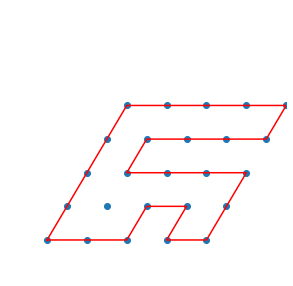

In [5]:
path_idx = 5

fig = render_skeleton(explorer.all_paths[path_idx])
fig.savefig('backbone.png')

# Adding hexagon kernals

In [6]:
#adding rotating kernals
rotations = np.random.choice(2, size ** 2).reshape((size, size))
rotations

array([[0, 0, 0, 1, 1],
       [1, 0, 1, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1]])

In [7]:
glyph_path = GlyphPath(explorer.all_paths[path_idx], rotations)
glyph_path.run_all()
result_series = glyph_path.return_series()
result_series

is_crossing                                                False
area                                                    8.948814
concavity                                               0.357953
distance                                                    24.0
solidity                                                0.372867
all_points     [(0.5, 0.2887), (0.6667, 0.5774), (0.8333, 0.8...
grid           [[1.0, 2.0, 3.0, 4.0, 5.0], [24.0, 0.0, 14.0, ...
rotations      [[0, 0, 0, 1, 1], [1, 0, 1, 1, 1], [0, 0, 1, 0...
dtype: object

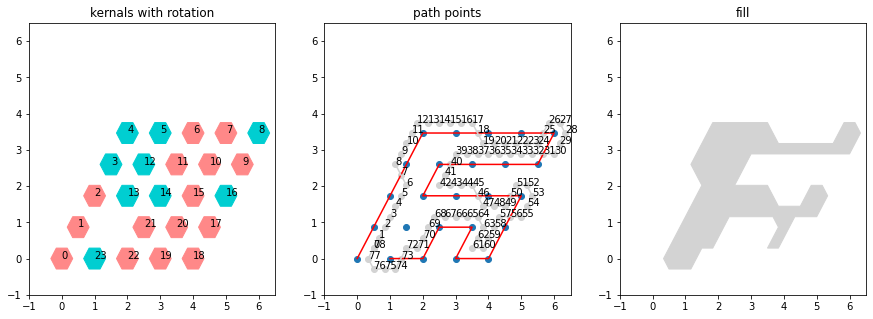

In [8]:
fig = render_path_debug(glyph_path)
fig.savefig('fill_in.png',bbox_inches='tight')

# Creating multiple glyphs



num_unique_cycles * 2**(length_of_cylces)


In [9]:
from tqdm import tqdm

successful_cylces = []
glyph_path_list = []
unsucessfull_glyph_path_list = []
unsucessfull_successful_cylces =[]
index = 0
target_value = 500
with tqdm(total=target_value) as pbar:
    
    while len(successful_cylces) < target_value:
        index = (index + 1) % len(explorer.all_paths)

        rotations = np.random.choice(2, size ** 2).reshape((size, size))
        glyph_path = GlyphPath(explorer.all_paths[index], rotations)
        glyph_path.run_all()
        result_series = glyph_path.return_series()
        if not result_series['is_crossing']:
            successful_cylces.append(result_series)
            glyph_path_list.append(glyph_path)
            pbar.update(1)
        else:
            unsucessfull_successful_cylces.append(result_series)
            unsucessfull_glyph_path_list.append(glyph_path)
            
result_df = pd.DataFrame(successful_cylces)
result_df['glyph_objects'] = glyph_path_list

100%|█████████████████████████████████████████| 500/500 [00:14<00:00, 35.69it/s]


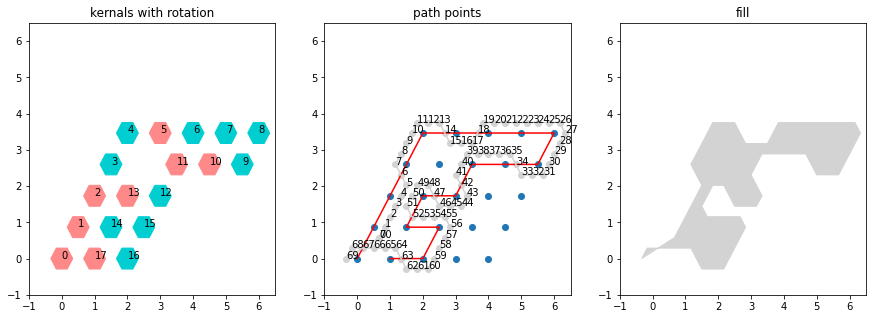

In [10]:
fig = render_path_debug(unsucessfull_glyph_path_list[10])
fig.savefig('nubbly.png')



In [11]:
# compare by solidity 

lowest solidity
highest solidity


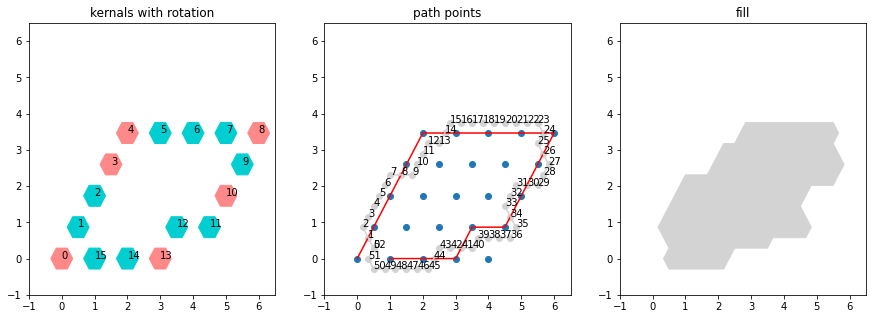

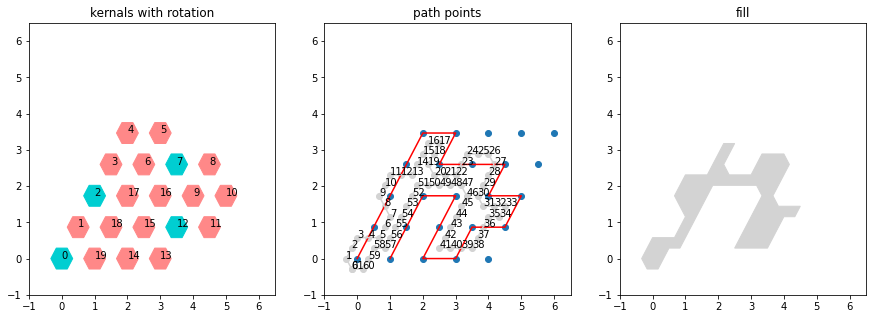

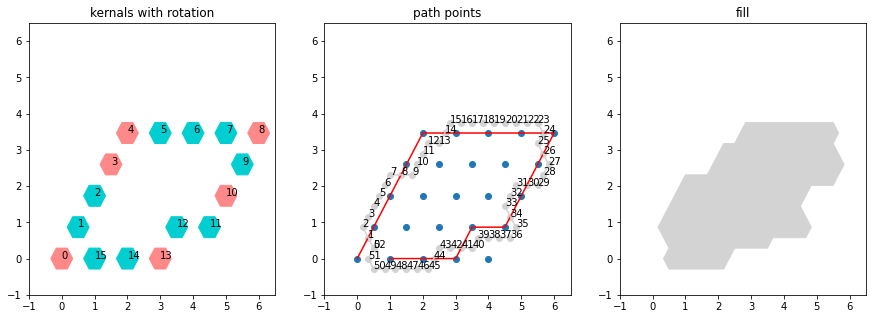

In [12]:
sorted_df =result_df.sort_values(by='solidity')

print('lowest solidity')
lowest_solidity = sorted_df['glyph_objects'].values[0]

render_path_debug(lowest_solidity)

print('highest solidity')

highest_solidity = sorted_df['glyph_objects'].values[-1]

render_path_debug(highest_solidity)


lowest distance
highest distance


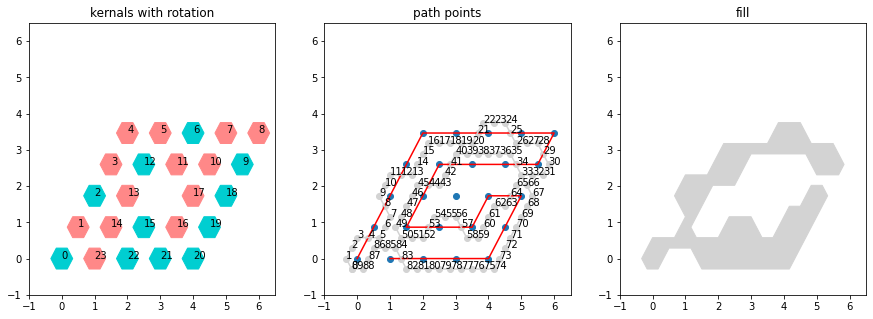

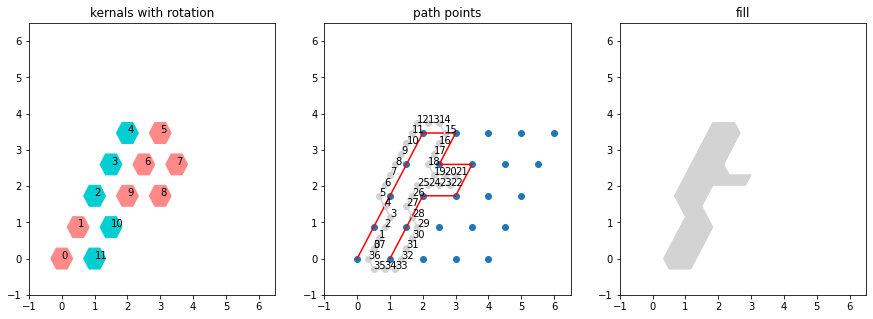

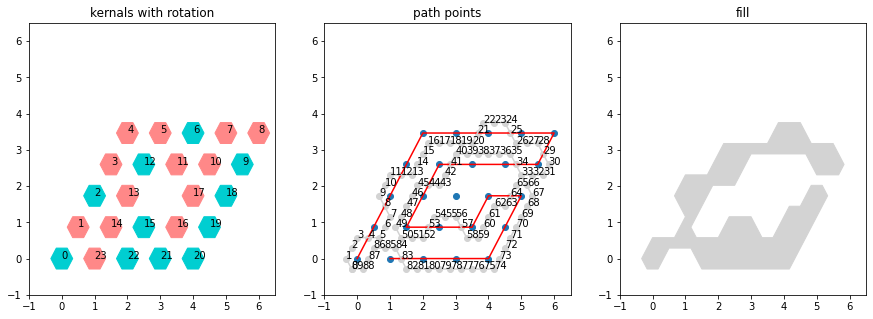

In [13]:
sorted_df =result_df.sort_values(by='distance')

print('lowest distance')
lowest_solidity = sorted_df['glyph_objects'].values[0]

render_path_debug(lowest_solidity)

print('highest distance')

highest_solidity = sorted_df['glyph_objects'].values[-1]

render_path_debug(highest_solidity)

# multiple plots

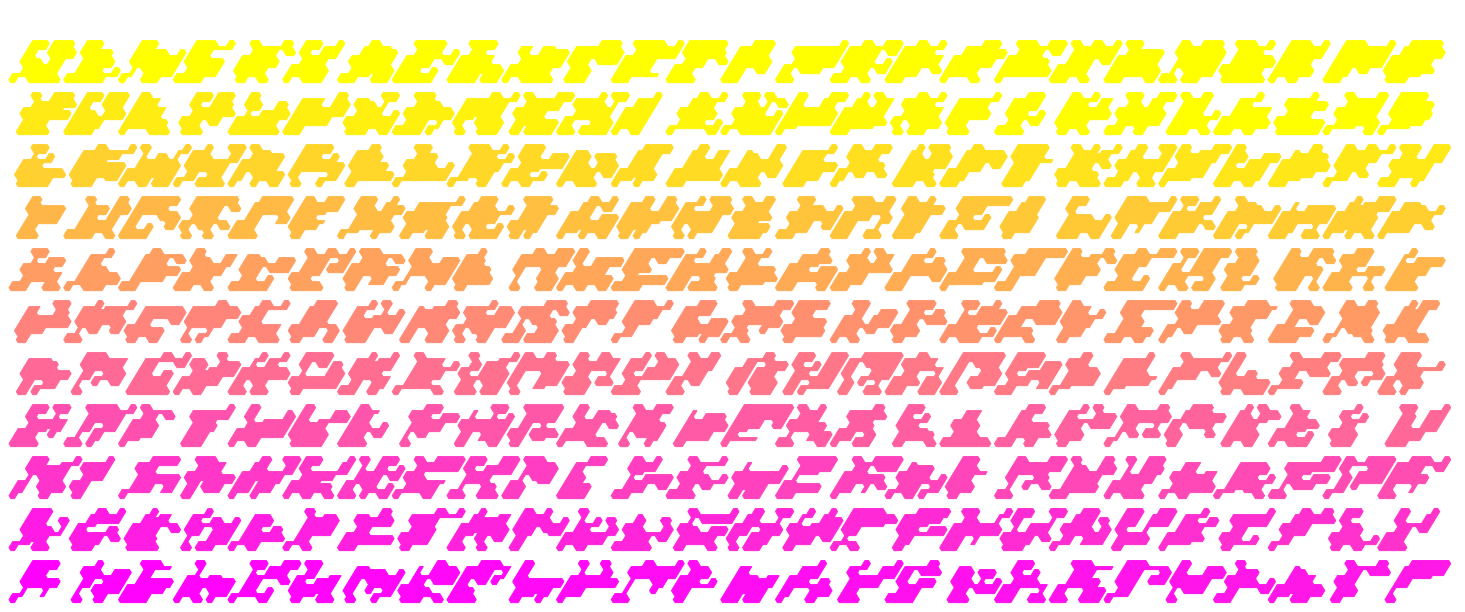

In [107]:
sorted_df =result_df.sort_values(by='concavity')
glyphs = sorted_df.tail(286)['glyph_objects'].values.tolist()

fig= render_multipath_fill(glyphs,save_location ='color_sweep_strip_2.png',color_profile='spring',width_height_ratio=1.5)

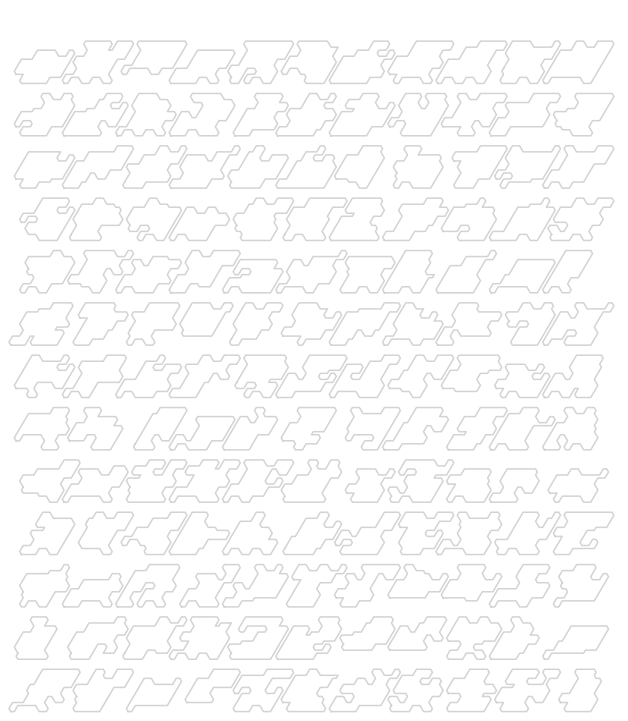

In [62]:
sorted_df =result_df.sort_values(by='concavity')
glyphs = sorted_df.tail(143)['glyph_objects'].values.tolist()
fig =render_multipath_lines(glyphs,save_location =None,width_height_ratio=.85)

In [63]:
fig.savefig('concavity_overlay.svg',bbox_inches='tight',pad_inches=0)

In [25]:
# Interpolation

In [28]:
from shapely.geometry import Polygon



In [52]:
pairwise_delta = np.zeros((len(result_df),len(result_df)))

for idx1, row1 in tqdm(result_df.iterrows(), total=result_df.shape[0]):

    for idx2,row2 in result_df.iterrows():
        polygon1 = Polygon(row1.all_points)
        polygon2 = Polygon(row2.all_points)
        pairwise_delta[[idx1,idx2]] = polygon2.difference(polygon1).area


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:56<00:00,  4.31it/s]


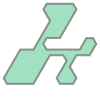

In [59]:
Polygon(row2.all_points)

In [60]:
polygon2.difference(polygon1).area

0.0

In [53]:

max_index = np.unravel_index(np.argmax(pairwise_delta), pairwise_delta.shape)
max_index

(100, 0)

In [54]:
min_index = np.unravel_index(np.argmin(pairwise_delta), pairwise_delta.shape)
min_index

(499, 0)

In [61]:
p1 = Polygon(result_df.iloc[0].all_points)
p2 = Polygon(result_df.iloc[0].all_points)

In [62]:
p2.difference(p1).area

0.0

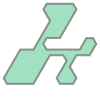

In [56]:
Polygon(result_df.iloc[499].all_points)

# Next steps
* assemble glyphs in way that resembles natural language
* create longest possible path with greatest number of convolutions
* remove nubblies 


In [402]:
result_df['glyph_objects'].values.tolist()